# Tweet Sentiment NLP

This notebook covers sentiment analysis for a collection of 1.6 million tweets, sourced from this Kaggle [dataset](https://www.kaggle.com/kazanova/sentiment140). My goal is build a series of machine learning models that can predict document polarity reasonably accurately, with each attempt attacking the classification problem from a different natural language processing approach and level of sophistication. The below code can be split into two sections: generalized text preprocessing, and single-layer model evaluation. 

## Generalized Text Preprocessing

For the generalized text preprocessing section, modifications made are only those that do not intentionally "lose" tweet information (i.e. no dropping words or ther destructive changes). This then leaves only formatting, standardization, and other methods of purely data cleaning. See the "general_preprocessing" function for a full list and order of all data preparation techniques used. A general summary of changes made is as follows: replacing urls, usernames, emoticons, and unrecognized characters with words; expanding contractions and common abbreviations; removing all non-alphanumeric characters; and truncating egregiously long sequences of repeated characters. This should then leave the corpus comprised solely of recognized English language words and numbers.

In [33]:
# check if modules are installed
from subprocess import Popen, PIPE

output = Popen("pip list | awk '{print $1}'", shell = True, stdout=PIPE).stdout.read().split()
packages = [x.decode('utf-8') for x in output][2:]
modules = ['contractions', 'hyperopt', 'kaggle', 'nltk', 'pandas', 'seaborn', 'scikit-learn']
for nm in modules:
    if nm not in packages:
        !pip install {nm}

In [76]:
# importing modules and setup
import contractions
import csv
import glob
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
import pandas as pd
import pickle
import re
import seaborn as sns
import time
import zipfile
from hyperopt import fmin, hp, tpe, STATUS_OK, Trials
from kaggle.api.kaggle_api_extended import KaggleApi
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedShuffleSplit
from sklearn.naive_bayes import MultinomialNB

In [3]:
# downloading dataset
if not os.path.isfile('df_data.pkl'):
    api = KaggleApi()
    api.authenticate()
    dataset = 'kazanova/sentiment140'
    csv_name = 'training.1600000.processed.noemoticon.csv'
    try:
        os.remove(csv_name)
    except:
        pass
    api.dataset_download_file(dataset, file_name=csv_name, path='./')
    fn = glob.glob('train*.zip', recursive = True)[0]
    with zipfile.ZipFile(fn) as zip_file:
        for file in zip_file.namelist():
            if file == csv_name:
                zip_file.extract(csv_name)
    os.remove(fn)
else:
    print('Skipping because df_data.pkl exists.')

Skipping because df_data.pkl exists.


In [4]:
# importing data
if not os.path.isfile('df_data.pkl'):
    columns = ['target', 'text']
    df_data = pd.read_csv(csv_name, usecols = [0, 5], header = None, names = columns)
    print(f'df_data dimensions: {df_data.shape}')
    df_data.head()
else:
    print('Skipping because df_data.pkl exists.')

Skipping because df_data.pkl exists.


In [5]:
# importing emoticon descriptions
if not os.path.isfile('df_data.pkl'):
    df_repl = pd.read_csv('emoticon_descriptions.csv', header = 0, usecols =[0, 1], \
        names = ['emoticon', 'description'])
    print(f'df_repl dimensions: {df_repl.shape}')
    df_repl.head()
else:
    print('Skipping because df_data.pkl exists.')

Skipping because df_data.pkl exists.


In [6]:
# moving to dictionary
if not os.path.isfile('df_data.pkl'):
    dict_emot = {a:b for a, b in zip(df_repl.iloc[:, 0], df_repl.iloc[:, 1])}
else:
    print('Skipping because df_data.pkl exists.')

Skipping because df_data.pkl exists.


In [7]:
# adding html replacements
if not os.path.isfile('df_data.pkl'):
    dict_emot['&quot;'] = 'quote'
    dict_emot['&amp;'] = 'and'
    dict_emot['&lt;'] = 'less than'
    dict_emot['&gt;'] = 'greater than'
else:
    print('Skipping because df_data.pkl exists.')

Skipping because df_data.pkl exists.


In [8]:
# creating dictionary of common abbreviations
if not os.path.isfile('df_data.pkl'):
    df_repl = pd.read_csv('common_abbreviations.csv').applymap(lambda x: x.lower())
    dict_abbr = {a:b for a, b in zip(df_repl.iloc[:, 0], df_repl.iloc[:, 1])}
else:
    print('Skipping because df_data.pkl exists.')

Skipping because df_data.pkl exists.


In [9]:
# general preprocessing tweet body text
def general_preprocess(text):
    '''
    Returns a generally-applicable preprocessed version of the passed string.

        Parameters:
            text (str) : passed string
        
        Returns:
            mod_text (str) : preprocessed string
    '''

    # add leading and trailing whitespace
    mod_text = ' ' + text + ' '

    # replace usernames
    mod_text = re.sub(r'(?<=\s)(@\S+)(?=\s)', ' USER ', mod_text)
    
    # replace urls
    mod_text = re.sub(r'(?<=\s)(https?:\/\/\S+)(?=\s)', ' URL ', mod_text)
    
    # replace non-space whitespace
    mod_text = re.sub(r'\s+', ' ', mod_text)
    
    # replace emoticons with text
    for i, k in dict_emot.items():
        mod_text = mod_text.replace(i, f' {k} ')
    
    # replace unrecognized characters
    mod_text = mod_text.replace('İ', 'I')
    
    # expand contractions
    mod_text = contractions.fix(mod_text)

    # remove non-alphanumeric characters
    mod_text = re.sub(r'[^a-zA-Z0-9]', ' ', mod_text)

    # lower case text
    mod_text = mod_text.lower()

    # truncate repeated characters
    mod_text = re.sub(r'(.)\1{2,}', r'\1\1', mod_text)

    # replace common abbreviations
    for i, k in dict_abbr.items():
        mod_text = mod_text.replace(f' {i} ', f' {k} ')
    
    # remove repeated spaces
    mod_text = re.sub(r'( )\1+', ' ', mod_text)

    # trim leading / trailing whitespace
    mod_text = mod_text.strip()

    return mod_text


In [10]:
# apply function to dataframe
if not os.path.isfile('df_data.pkl'):
    df_data.loc[:, 'text'] = df_data['text'].apply(general_preprocess)
    df_data.head()
else:
    print('Skipping because df_data.pkl exists.')

Skipping because df_data.pkl exists.


In [11]:
# doing some pickling
if not os.path.isfile('df_data.pkl'):
    df_data.to_pickle('df_data.pkl')
else:
    print('Skipping because df_data.pkl exists.')

Skipping because df_data.pkl exists.


### More Processing

The most basic version of natural language encoding identifies documents by unique sets of word tokens and counts. The ML models in this section will all be trained using an optimized variant of this method, term frequency-inverse document frequency vectors. TF-IDF weights the word token counts to highlight words that are more important to a document, while vectorization converts the string of text into a more machine-comprehensible vector of numbers.

Two constraints will be used to futher filter and simplify our corpus dictionary: removing stopwords, and lemmatization. Both techniques will result in a loss of contextual information, hence their absence from the prior section, though this is a necessary tradeoff to keep our vector space small.

In [12]:
# downloading stopwords and lemmas from nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
nltk.download('wordnet')
lemma = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/parkernisbet/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/parkernisbet/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [13]:
# additional preprocessing for machine learning methods
def sl_preprocess(text):
    '''
    Returns a preprocessed version of the passed string useful for single layer methods.
    
        Parameters:
            text (str) : passed string
        
        Returns:
            mod_text (str) : preprocessed string
    '''
    
    # split string into tokens, removing stopwords and single characters, lemmatize
    mod_text = ' '.join([lemma.lemmatize(i) for i in text.split() if len(i) > 1 if i not in stop_words])

    return mod_text

In [14]:
# applying function to dataframe
if not os.path.isfile('df_data_sl.pkl'):
    df_data.loc[:, 'text'] = df_data['text'].apply(sl_preprocess)
    df_data.head()
else:
    print('Skipping because df_data_sl.pkl exists.')

Skipping because df_data_sl.pkl exists.


In [15]:
# saving to pickle
if not os.path.isfile('df_data_sl.pkl'):
    df_data.to_pickle('df_data_sl.pkl')
else:
    df_data = pd.read_pickle('df_data_sl.pkl')
    print("df_data_sl.pkl read into df_data.")

df_data_sl.pkl read into df_data.


In [16]:
# test train split
sss = StratifiedShuffleSplit(n_splits = 1, test_size = .2, random_state = 3)
sss.get_n_splits(df_data.text, df_data.target)
for train_ind, test_ind in sss.split(df_data.text, df_data.target):
    pass
print(f'Train_ind shape: {train_ind.shape}\nTest_ind shape: {test_ind.shape}')


Train_ind shape: (1280000,)
Test_ind shape: (320000,)


In [17]:
# tfidf vectorizing
vectorizer = TfidfVectorizer(analyzer = 'word', max_features = 300000)
X_train = vectorizer.fit_transform(df_data.text[train_ind].reset_index(drop = True))
y_train = df_data.target[train_ind].reset_index(drop = True)
X_test = vectorizer.transform(df_data.text[test_ind].reset_index(drop = True))
y_test = df_data.target[test_ind].reset_index(drop = True)

## Model Evaluation

The vectorizer object above converts the dataframe of strings into a sparse matrix, so this slightly limits which sklearn models we can use for prediction. A detailed list of compatible methods can be found [here](https://dziganto.github.io/Sparse-Matrices-For-Efficient-Machine-Learning/), however this notebook will only cover a small subset of sklearn's classifiers:

    - LogisticRegression
    - MultinomialNB
    - RandomForestClassifier

In [18]:
# dictionary for storing model performance
model_perf = {}

### Logistic Regression

In [51]:
# grid searching for optimal c values
params = {'C': [.001, .005, .01, .05, .1, .5, 1, 5]}
if not os.path.isfile('clf_lr.pkl'):
    model = LogisticRegression(max_iter = 1000, random_state = 4)
    clf = GridSearchCV(model, param_grid = params, n_jobs = -1)
    clf.fit(X_train, y_train)
    pickle.dump(clf, open('clf_lr.pkl', 'wb'))
else:
    clf = pickle.load(open('clf_lr.pkl', 'rb'))

In [52]:
# best parameter value and score
print(f'Optimal alpha: {clf.best_params_}, score: {clf.best_score_}')

Optimal alpha: {'C': 0.5}, score: 0.7775796875000001


The last five model fits (cross validation for C = 10) did not converge completely, though can be ignored based on the GridSearch results in the next cell. C values greater than 1 start to drop off in accuracy, along with longer fit times.

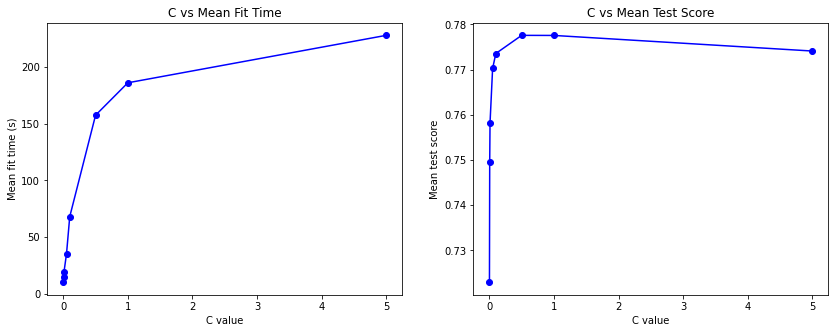

In [53]:
# visualizing gridsearch results
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(14, 5)
ax1.plot(params['C'], clf.cv_results_['mean_fit_time'], 'b-o')
ax1.set_xlabel('C value')
ax1.set_ylabel('Mean fit time (s)')
ax1.set_title('C vs Mean Fit Time')
ax2.plot(params['C'], clf.cv_results_['mean_test_score'], 'b-o')
ax2.set_xlabel('C value')
ax2.set_ylabel('Mean test score')
ax2.set_title('C vs Mean Test Score')
plt.show()

Based on the right line chart we should expect to see a global optimal C value between C = .5 and C = 5, which corresponds with the absolute maximum model accuracy. Another GridSearch with more granular exploration between .5 and ~2.5 should yield this true global optimal C value, but as C values increase so do their fit times. For this notebook, the accuracy of C = 1 is good enough.

Test accuracy = 0.77876875


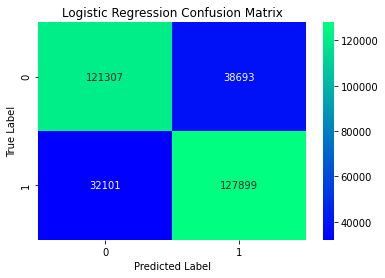

Fit time: 61.24584770202637
Predict time: 0.007815837860107422


In [54]:
# storing model accuracy, time, and confusion matrix
C = clf.best_params_['C']
model = LogisticRegression(C = C, max_iter = 1000, random_state = 4)
t1 = time.time()
model.fit(X_train, y_train)
t2 = time.time()
y_pred = model.predict(X_test)
t3 = time.time()
acc = np.sum(y_pred == y_test)/y_pred.shape[0]
fit_time = t2 - t1
pred_time = t3 - t2
c_mat = confusion_matrix(y_test, y_pred)
model_perf['LogisticRegression'] = (acc, c_mat, (fit_time, pred_time))
print(f'Test accuracy = {acc}')
sns.heatmap(c_mat, annot = True, fmt = 'd', cmap = 'winter')
plt.title('Logistic Regression Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
print(f'Fit time: {fit_time}\nPredict time: {pred_time}')

### Multinomial Naive Bayes

In [55]:
# grid search for optimal alpha variable
params = {'alpha': np.linspace(0, 200)}
if not os.path.isfile('clf_nb.pkl'):
    model = MultinomialNB()
    clf = GridSearchCV(model, params, n_jobs = -1)
    clf.fit(X_train, y_train)
    pickle.dump(clf, open('clf_nb.pkl', 'wb'))
else:
    clf = pickle.load(open('clf_nb.pkl', 'rb'))

In [56]:
# best parameter value and score
print(f'Optimal alpha: {clf.best_params_}, score: {clf.best_score_}')

Optimal alpha: {'alpha': 12.244897959183675}, score: 0.7654875000000001


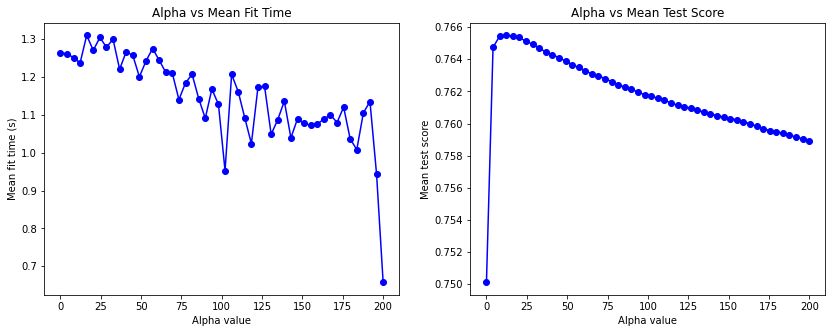

In [57]:
# visualizing gridsearch results
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(14, 5)
ax1.plot(params['alpha'], clf.cv_results_['mean_fit_time'], 'b-o')
ax1.set_xlabel('Alpha value')
ax1.set_ylabel('Mean fit time (s)')
ax1.set_title('Alpha vs Mean Fit Time')
ax2.plot(params['alpha'], clf.cv_results_['mean_test_score'], 'b-o')
ax2.set_xlabel('Alpha value')
ax2.set_ylabel('Mean test score')
ax2.set_title('Alpha vs Mean Test Score')
plt.show()

The optimal alpha value among those GridSearched was ~12.245, with an accuracy of 76.55%.

Test accuracy = 0.766540625


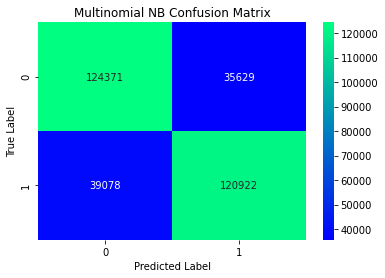

Fit time: 0.17394375801086426
Predict time: 0.013525009155273438


In [58]:
# storing model time, accuracy, and confusion matrix
alpha = clf.best_params_['alpha']
model = MultinomialNB(alpha = alpha)
t1 = time.time()
model.fit(X_train, y_train)
t2 = time.time()
y_pred = model.predict(X_test)
t3 = time.time()
acc = np.sum(y_pred == y_test)/y_pred.shape[0]
fit_time = t2 - t1
pred_time = t3 - t2
c_mat = confusion_matrix(y_test, y_pred)
model_perf['MultinomialNB'] = (acc, c_mat, (fit_time, pred_time))
print(f'Test accuracy = {acc}')
sns.heatmap(c_mat, annot = True, fmt = 'd', cmap = 'winter')
plt.title('Multinomial NB Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
print(f'Fit time: {fit_time}\nPredict time: {pred_time}')

### Random Forest Classifier